In [20]:
import torch
import sys
sys.path.append('../')
from DataType.ElectricField import ElectricField
from LightSource.Gaussian_beam import Guassian_beam
from Props.ASM_Prop import ASM_prop
from Props.RSC_Prop import RSC_prop
from Components.Thin_Lens import Thin_LensElement
from Components.Aperture import ApertureElement
from Components.QuantizedDOE import SoftGumbelQuantizedDOELayerv3 as SoftGumbelQuantizedDOELayer
from Components.QuantizedDOE import NaiveGumbelQuantizedDOELayer
from Components.QuantizedDOE import PSQuantizedDOELayer
from Components.QuantizedDOE import STEQuantizedDOELayer
from Components.QuantizedDOE import FullPrecisionDOELayer
from utils.Helper_Functions import normalize, DOE_xyz_cordinates_Generator
from utils.units import *
import numpy as np
import scipy.io
import time
import torch.nn as nn

from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 1. Define the DOE's parameters and optimization target

In [21]:
# Hologram parameters (high-temp resin)
epsilon = 2.66
tand = 0.03
    
input_field_shape = [100, 100]
input_dxy = 1 * mm
doe_shape = [100, 100]
doe_dxy = 1 * mm
    
    
c0 = 2.998e8
f2 = 300e9  # 0.3 THz

wavelengths = c0 / f2
#print("The number of wavelengths: " +  str(wavelengths.shape[0]))

# all parameters of DOE optimization
doe_params = {
    'doe_size': doe_shape,
    'doe_dxy' : doe_dxy,
    'doe_level': 4,
    'look_up_table': None,
    'num_unit': 2,
    'height_constraint_max': 1 * mm,
    'tolerance': 10 * um,  
    'material': [epsilon, tand]
}

optim_params = {
    'c_s': 100,   # a number to boost the score (higher more robust to gumbel noise)
    'tau_max': 2.5, # maximum value of tau
    'tau_min': 1.5  # minimum value of tau
}

In [22]:
def define_FoM(resolution, sampling_size, wavelength, focal_length, position):
    """
    Calculates the Full-width-at-half-maximum (FWHM) by the far-field diffraction limit
    and applies it to model the point spread function (PSF) as a Gaussian function, with consistent intensity across positions.
    
    Parameters:
        resolution (tuple): The resolution of the field in pixels (height, width).
        sampling_size (float): The physical size of each pixel, in meters.
        wavelength (float): The wavelength of the light, in meters.
        focal_length (float): The focal length of the optical system, in meters.
        position (tuple): The target position in the field, in meters (x, y).
        
    Returns:
        torch.Tensor: The calculated and normalized PSF as a 2D Gaussian function over the specified field.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    height, width = resolution
    Length_x = sampling_size * width
    Length_y = sampling_size * height
    
    effective_L = torch.sqrt(torch.tensor((Length_x ** 2 + Length_y ** 2), device=device))
    NA = torch.sin(torch.atan(effective_L / (2 * focal_length)))
    FWHM = wavelength / (2 * NA)
    
    x_grid, y_grid = torch.meshgrid(torch.linspace(-Length_x / 2, Length_x / 2, steps=width, device=device),
                                    torch.linspace(-Length_y / 2, Length_y / 2, steps=height, device=device))
    
    x_position, y_position = torch.tensor(position, device=device)
    
    # Calculate the Gaussian PSF
    PSF = torch.exp(-((x_grid - x_position) ** 2 + (y_grid - y_position) ** 2) / ((FWHM*2) ** 2))
    
    # Normalize the PSF such that its maximum value is 1
    
    return normalize(PSF.unsqueeze(0).unsqueeze(0))

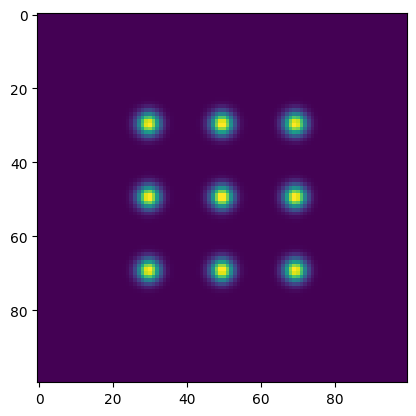

In [23]:
PSF_1 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[-20*mm, -20*mm])

PSF_2 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[20*mm, 20*mm])

PSF_3 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[-20*mm, 20*mm])

PSF_4 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[20*mm, -20*mm])

PSF_5 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[0*mm, 0*mm])

PSF_6 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[0*mm, -20*mm])

PSF_7 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[-20*mm, 0*mm])

PSF_8 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[0*mm, 20*mm])

PSF_9 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[20*mm, 0*mm])

target = PSF_1 + PSF_2 + PSF_3 + PSF_4 + PSF_5 + PSF_6 + PSF_7 + PSF_8 + PSF_9
plt.imshow(target[0, 0, :, :].cpu())

# 2. Define the System with SoftGumbelQuantizedDOE 

In [24]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        #self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
        #                    bandlimit_type='exact', 
        #                    padding_scale=2, 
        #                    bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = SoftGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        
        
        self.asm_prop3 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [25]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [26]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []

optimizer = torch.optim.Adam(setup.parameters(), lr=0.02)
setup.cuda()
target = target.cuda()
photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths)
    
    if loss < best_loss and itr > max_itrs * 0.8:
        best_setup = setup
        best_loss = loss
        best_field = out_field

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.038325417786836624
The iteration : 200, Loss: 0.0019093245500698686
The iteration : 400, Loss: 0.0004295761464163661
The iteration : 600, Loss: 0.0002256530278827995
The iteration : 800, Loss: 0.0001460285420762375
The iteration : 1000, Loss: 0.0001042346193571575
The iteration : 1200, Loss: 7.912715227575973e-05
The iteration : 1400, Loss: 6.210454739630222e-05
The iteration : 1600, Loss: 4.98281697218772e-05
The iteration : 1800, Loss: 4.1107949073193595e-05
The iteration : 2000, Loss: 3.7830865039722994e-05
The iteration : 2200, Loss: 3.910814120899886e-05
The iteration : 2400, Loss: 3.828896296909079e-05
The iteration : 2600, Loss: 3.566624945960939e-05
The iteration : 2800, Loss: 4.8661702749086544e-05
The iteration : 3000, Loss: 6.891494558658451e-05
The iteration : 3200, Loss: 6.182261859066784e-05
The iteration : 3400, Loss: 9.718458022689447e-05
The iteration : 3600, L

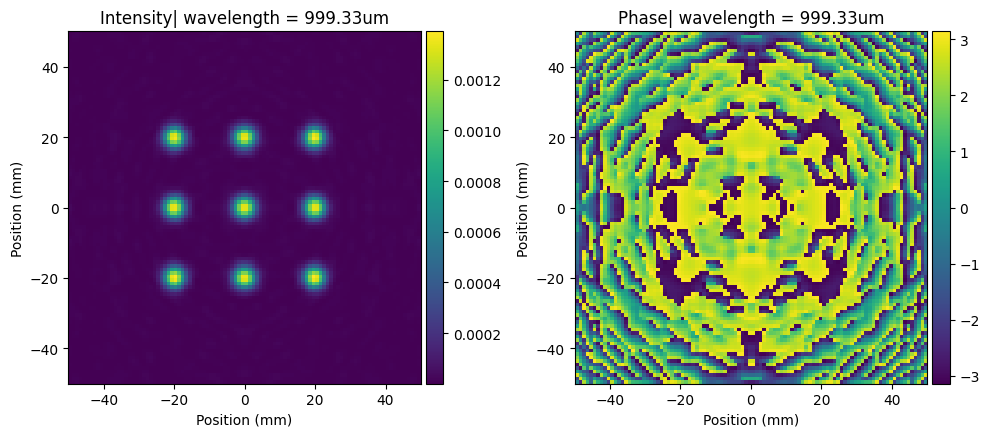

In [27]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

In [28]:
best_loss

tensor(4.7417e-05, device='cuda:0', grad_fn=<MseLossBackward0>)

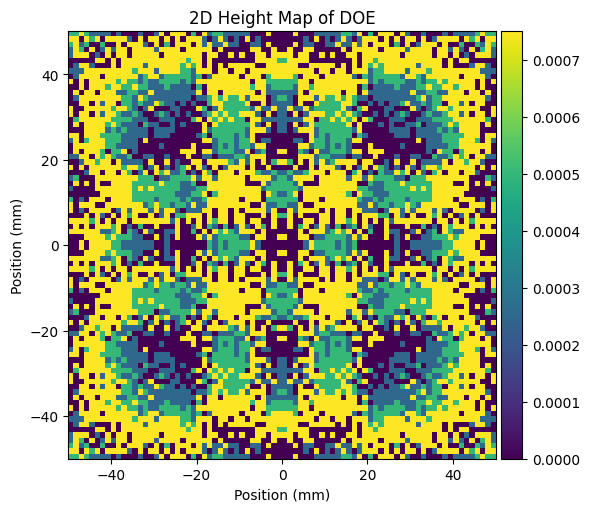

In [29]:
best_setup.doe.visualize(figsize=(6,6), crop_size=[80, 80])

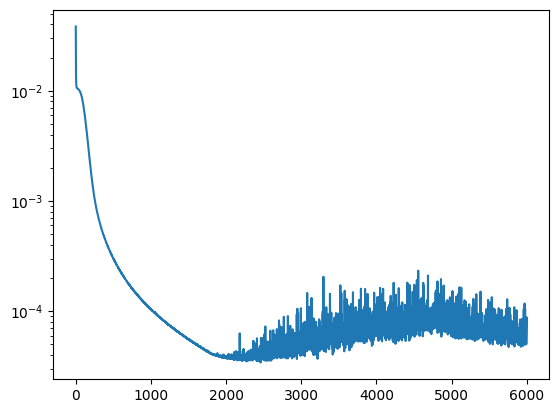

In [30]:
plt.plot(losses)
plt.yscale('log')

In [31]:
#best_setup.doe.save(crop_size=[80, 80])
np.save('loss_curve_Ours.npy', losses)

In [199]:
#data = np.load('height_map_20240819-120511.npy', allow_pickle=True)
#thickness = data.item().get('thickness')
#dxy = data.item().get('dxy')
#plt.imshow(thickness)
#DOE_xyz_cordinates_Generator(thickness, dxy, new_dxy=dxy, for_matlab=False)

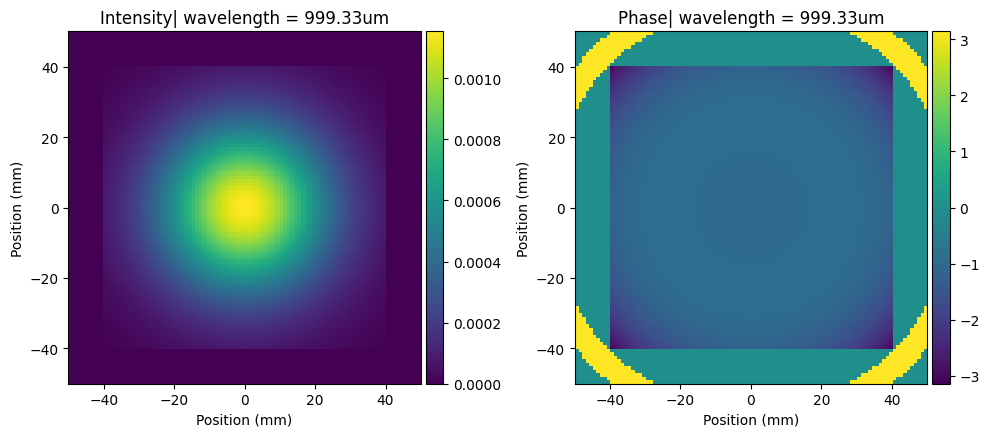

In [200]:
best_setup.input_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

In [201]:
best_setup.doe.height_map.unique() / mm

#best_loss / mm

tensor([0.0000, 0.2500, 0.5000, 0.7500], device='cuda:0',
       grad_fn=<DivBackward0>)

# 3. Define the System with FullPrecisionDOE

In [32]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = FullPrecisionDOELayer(self.doe_params)
        
        
        self.asm_prop3 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [33]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [34]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []

optimizer = torch.optim.AdamW(setup.parameters(), lr=0.02)
setup.cuda()
target = target.cuda()
photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths)
    
    if loss < best_loss:
        best_loss = loss
        best_field = out_field

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.03404144197702408
The iteration : 200, Loss: 0.001517218304798007
The iteration : 400, Loss: 0.00040457790601067245
The iteration : 600, Loss: 0.00022237376833800226
The iteration : 800, Loss: 0.0001544274273328483
The iteration : 1000, Loss: 0.00010337871935917065
The iteration : 1200, Loss: 8.380763028981164e-05
The iteration : 1400, Loss: 7.232163625303656e-05
The iteration : 1600, Loss: 6.247546843951568e-05
The iteration : 1800, Loss: 5.4767537221778184e-05
The iteration : 2000, Loss: 4.7153091145446524e-05
The iteration : 2200, Loss: 4.182640623184852e-05
The iteration : 2400, Loss: 3.6803747207159176e-05
The iteration : 2600, Loss: 3.20619874401018e-05
The iteration : 2800, Loss: 3.0938474083086476e-05
The iteration : 3000, Loss: 2.5745803213794716e-05
The iteration : 3200, Loss: 2.1950843802187592e-05
The iteration : 3400, Loss: 2.0112853235332295e-05
The iteration : 36

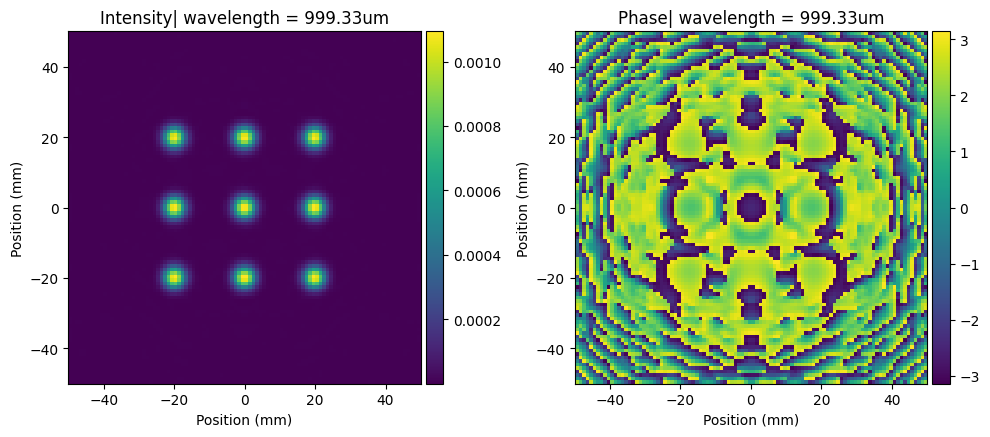

In [35]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

In [36]:
best_loss

tensor(6.3232e-06, device='cuda:0', grad_fn=<MseLossBackward0>)

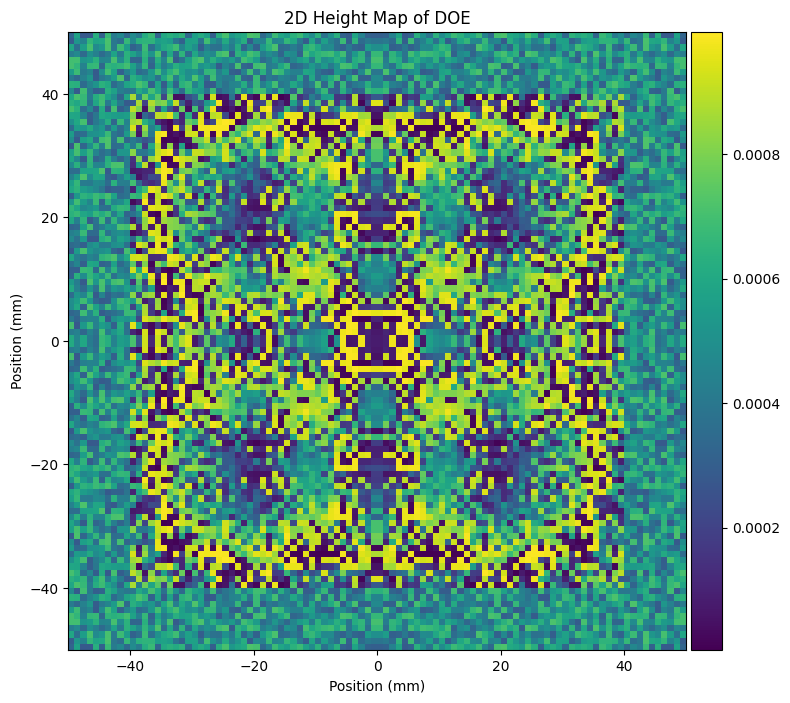

In [37]:
setup.doe.visualize(figsize=(8,8))

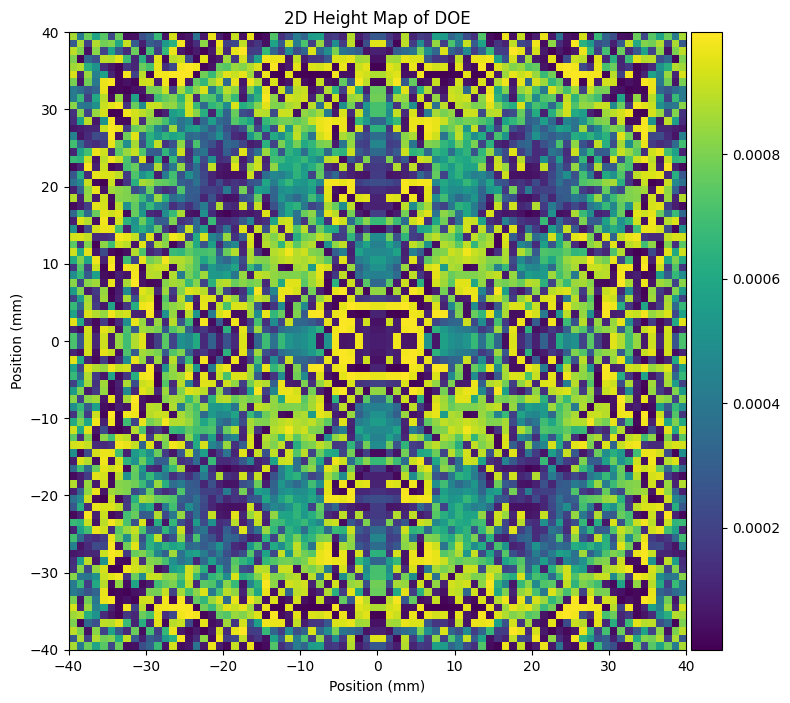

In [38]:
setup.doe.visualize(figsize=(8,8), crop_size=[80, 80])

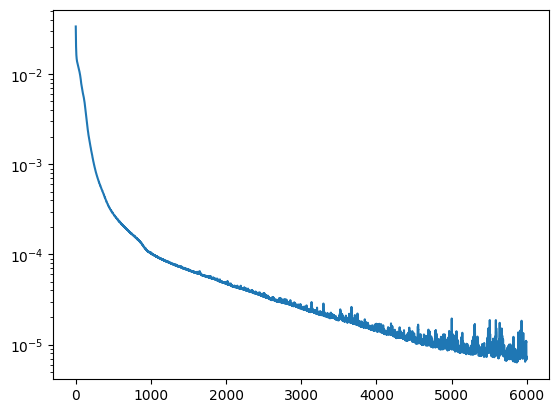

In [39]:
plt.plot(losses)
plt.yscale('log')

In [40]:
np.save('loss_curve_full.npy', losses)

In [41]:
#best_setup.doe.save(crop_size=[80, 80])

# 4. System with NaiveGumbelQuantizedDOELayer

In [43]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = NaiveGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        
        
        self.asm_prop3 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [44]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [45]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []

optimizer = torch.optim.AdamW(setup.parameters(), lr=0.02)
setup.cuda()
target = target.cuda()
photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths)
    
    if loss < best_loss:
        best_setup = setup
        best_loss = loss
        best_field = out_field

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.03878266364336014
The iteration : 200, Loss: 0.010477656498551369
The iteration : 400, Loss: 0.008298642933368683
The iteration : 600, Loss: 0.004693898838013411
The iteration : 800, Loss: 0.00349953374825418
The iteration : 1000, Loss: 0.0025939722545444965
The iteration : 1200, Loss: 0.0024890757631510496
The iteration : 1400, Loss: 0.0015690515283495188
The iteration : 1600, Loss: 0.0016774991527199745
The iteration : 1800, Loss: 0.0014673350378870964
The iteration : 2000, Loss: 0.0009018999990075827
The iteration : 2200, Loss: 0.0010535380570217967
The iteration : 2400, Loss: 0.0008669848321005702
The iteration : 2600, Loss: 0.00086191640002653
The iteration : 2800, Loss: 0.0007990975282154977
The iteration : 3000, Loss: 0.0007604123675264418
The iteration : 3200, Loss: 0.0006447028717957437
The iteration : 3400, Loss: 0.0006500837043859065
The iteration : 3600, Loss: 0.000

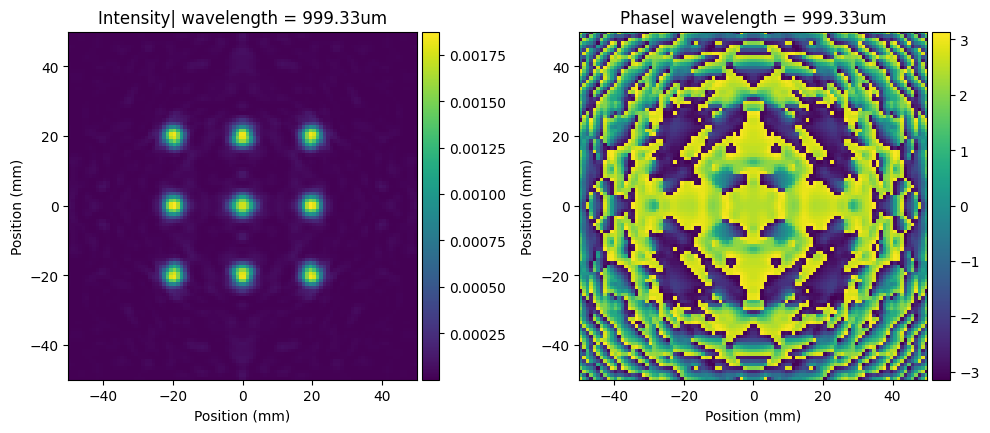

In [46]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

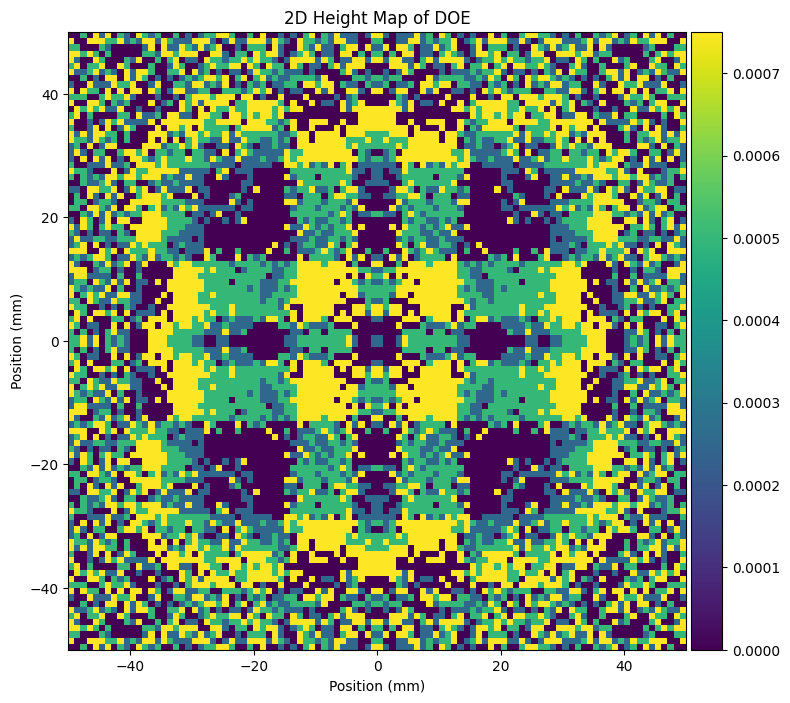

In [47]:
best_setup.doe.visualize(figsize=(8,8))

In [48]:
best_loss / 0.0001

tensor(2.0927, device='cuda:0', grad_fn=<DivBackward0>)

In [49]:
best_setup.doe.height_map.unique() / mm

tensor([0.0000, 0.2500, 0.5000, 0.7500], device='cuda:0',
       grad_fn=<DivBackward0>)

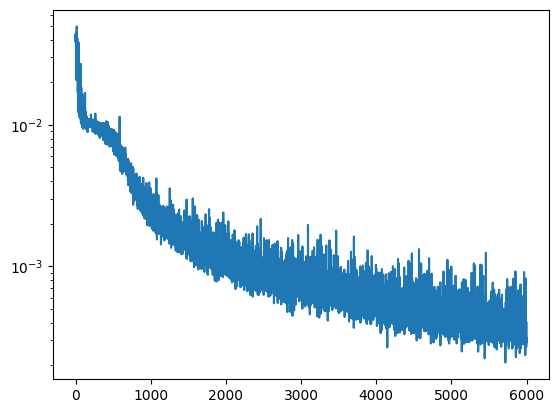

In [50]:
plt.plot(losses)
plt.yscale('log')

In [51]:
#best_setup.doe.save(crop_size=[80, 80])
np.save('loss_curve_GS.npy', losses)

# 5. System with PSQuantizedDOELayer

In [52]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = PSQuantizedDOELayer(self.doe_params, self.optim_params)
        
        
        self.asm_prop3 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [53]:
optim_params = {
    'c_s': 300,
    'tau_max': 400,
    'tau_min': 1
}
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [54]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []

optimizer = torch.optim.Adam(setup.parameters(), lr=0.02)
setup.cuda()
target = target.cuda()
photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths)
    
    if loss < best_loss:
        best_setup = setup
        best_loss = loss
        best_field = out_field

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.051946453750133514
The iteration : 200, Loss: 0.0007924588862806559
The iteration : 400, Loss: 0.0005039929528720677
The iteration : 600, Loss: 0.0004730989458039403
The iteration : 800, Loss: 0.0004819872847292572
The iteration : 1000, Loss: 0.0004833181155845523
The iteration : 1200, Loss: 0.0004927664413116872
The iteration : 1400, Loss: 0.00047582920524291694
The iteration : 1600, Loss: 0.0004879253392573446
The iteration : 1800, Loss: 0.0004966661217622459
The iteration : 2000, Loss: 0.0004955675103701651
The iteration : 2200, Loss: 0.000510436890181154
The iteration : 2400, Loss: 0.0005194046534597874
The iteration : 2600, Loss: 0.0005311411805450916
The iteration : 2800, Loss: 0.0005265717627480626
The iteration : 3000, Loss: 0.000535058556124568
The iteration : 3200, Loss: 0.0005394487525336444
The iteration : 3400, Loss: 0.0005308774998411536
The iteration : 3600, Loss

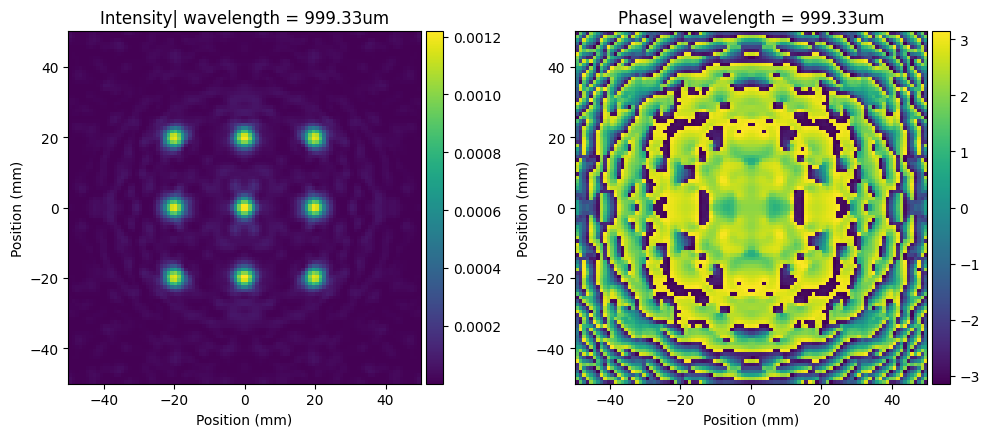

In [55]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

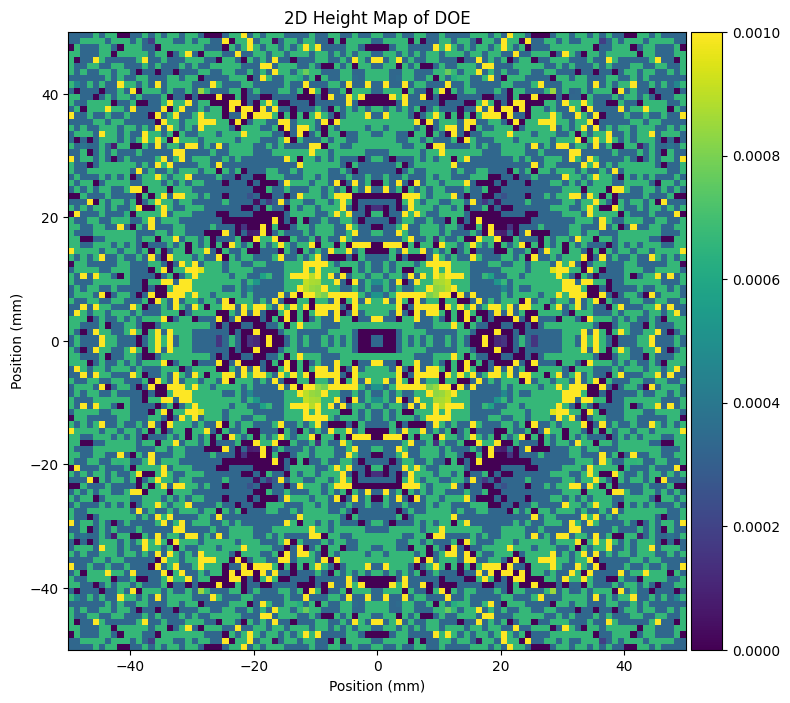

In [56]:
best_setup.doe.visualize(figsize=(8,8))

In [57]:
best_setup.doe.height_map.unique() / mm

tensor([0.0000e+00, 1.1715e-39, 1.3438e-39, 1.3971e-39, 4.3272e-39, 4.3805e-39,
        4.4267e-39, 4.7868e-39, 5.0363e-39, 1.0787e-38, 1.1300e-38, 1.4202e-38,
        2.8259e-38, 3.6414e-38, 8.0374e-38, 9.1676e-38, 1.0327e-37, 1.3307e-37,
        1.6902e-37, 1.7358e-37, 2.5295e-37, 4.0893e-37, 4.1196e-37, 5.4401e-37,
        1.3325e-36, 1.3343e-36, 2.0972e-36, 2.6348e-36, 9.4649e-36, 1.4677e-35,
        2.5346e-35, 3.5095e-35, 4.0263e-35, 7.3371e-35, 8.0539e-35, 1.1654e-34,
        1.2488e-34, 1.4429e-34, 2.7543e-34, 3.2446e-34, 4.2528e-34, 1.0561e-33,
        1.0912e-33, 1.2434e-33, 1.4149e-33, 1.7940e-33, 1.9286e-33, 2.2356e-33,
        3.0008e-33, 3.3500e-33, 3.8343e-33, 1.0474e-32, 1.5538e-32, 1.6356e-32,
        1.8184e-32, 3.1286e-32, 3.2100e-32, 4.0181e-32, 4.0927e-32, 5.7856e-32,
        7.1714e-32, 9.0563e-32, 1.0877e-31, 1.1203e-31, 1.5826e-31, 1.7882e-31,
        2.0166e-31, 2.5390e-31, 2.6781e-31, 3.2327e-31, 1.7513e-30, 2.6763e-30,
        2.9896e-30, 3.2604e-30, 3.4866e-

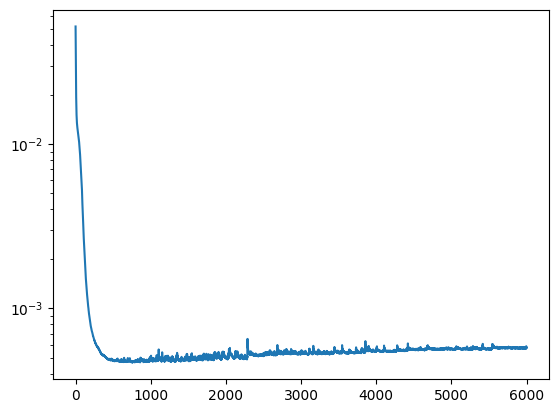

In [58]:
plt.plot(losses)
plt.yscale('log')

In [59]:
#best_setup.doe.save(crop_size=[80, 80])
np.save('loss_curve_PSQ.npy', losses)

# 6. System with STEQuantizedDOELayer 

In [60]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = STEQuantizedDOELayer(self.doe_params, self.optim_params)
        
        
        self.asm_prop3 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [61]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [62]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []

optimizer = torch.optim.AdamW(setup.parameters(), lr=0.02)
setup.cuda()
target = target.cuda()
photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths)
    
    if loss < best_loss:
        best_setup = setup
        best_loss = loss
        best_field = out_field

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.04648945480585098
The iteration : 200, Loss: 0.003049623453989625
The iteration : 400, Loss: 0.000704916485119611
The iteration : 600, Loss: 0.0004920119536109269
The iteration : 800, Loss: 0.00035570806358009577
The iteration : 1000, Loss: 0.0003764704742934555
The iteration : 1200, Loss: 0.00026974076172336936
The iteration : 1400, Loss: 0.0002584178000688553
The iteration : 1600, Loss: 0.0003269697481300682
The iteration : 1800, Loss: 0.00021151955297682434
The iteration : 2000, Loss: 0.00023724700440652668
The iteration : 2200, Loss: 0.0002321659994777292
The iteration : 2400, Loss: 0.00025069419643841684
The iteration : 2600, Loss: 0.00030985509511083364
The iteration : 2800, Loss: 0.00018665340030565858
The iteration : 3000, Loss: 0.00021855253726243973
The iteration : 3200, Loss: 0.00014957456733100116
The iteration : 3400, Loss: 0.000286415423033759
The iteration : 3600

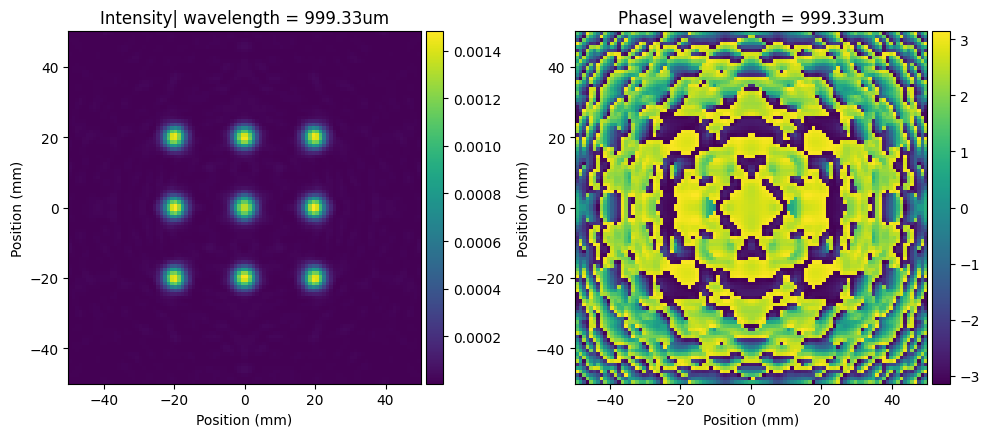

In [63]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

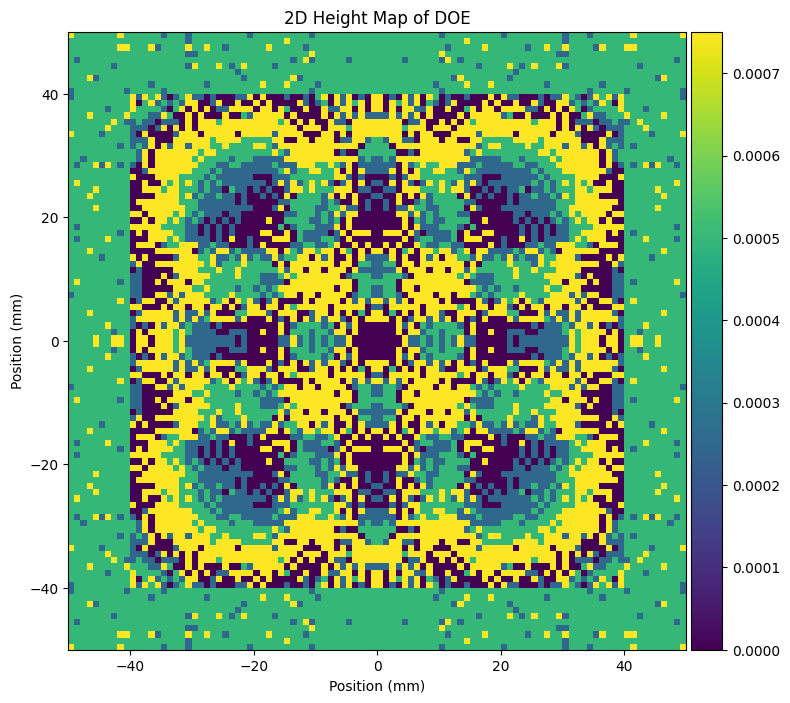

In [64]:
best_setup.doe.visualize(figsize=(8,8))

In [65]:
setup.doe.height_map.unique() / mm

tensor([0.0000, 0.2500, 0.5000, 0.7500], device='cuda:0',
       grad_fn=<DivBackward0>)

In [66]:
#best_setup.doe.save(crop_size=[80, 80])
np.save('loss_curve_STE.npy', losses)

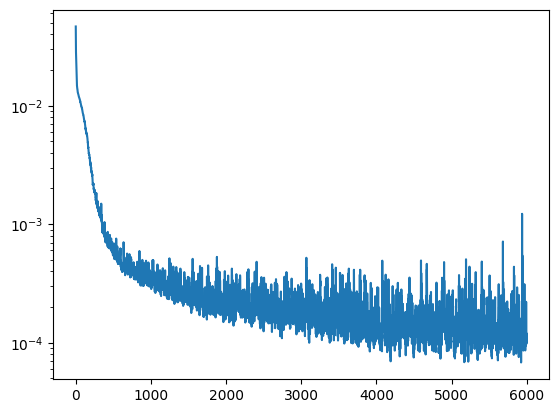

In [67]:
plt.plot(losses)
plt.yscale('log')

In [156]:
best_loss

tensor(6.5890e-05, device='cuda:0', grad_fn=<MseLossBackward0>)

## 1. Visualize for 1D distribution intensity=

In [ ]:
out_amp = normalize(torch.abs(out_field.data)**2)

In [ ]:
# 1D distribution for spot 1 and 2
from utils.Visualization_Helper import float_to_unit_identifier, add_colorbar
size_x = np.array(1 * mm * 100 / 2)
unit_val, unit_axis = float_to_unit_identifier(size_x)
size_x = size_x / unit_val

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
x_axis_spot_1_2 = out_amp[0, 0, :, 20]
x_axis_spot_1_2 = x_axis_spot_1_2.cpu().detach().numpy()
new_x_axis = np.linspace(-size_x, size_x, len(x_axis_spot_1_2))
plt.plot(new_x_axis, x_axis_spot_1_2)
plt.ylim([0,1])
plt.xlim([-size_x, size_x])
plt.xlabel("Position (" + unit_axis + ")")

plt.subplot(1, 2, 2)
x_axis_spot_3_4 = out_amp[0, 0, :, 80]
x_axis_spot_3_4 = x_axis_spot_3_4.cpu().detach().numpy()
plt.plot(new_x_axis, x_axis_spot_3_4)
plt.ylim([0,1])
plt.xlim([-size_x, size_x])
plt.xlabel("Position (" + unit_axis + ")")
plt.tight_layout()

## 2. Visualize for 2D quantized phase map of DOE

In [69]:
setup.hologram.q_phase.unique()

tensor([0.0000, 1.5708, 3.1416, 4.7124], device='cuda:0',
       grad_fn=<Unique2Backward0>)

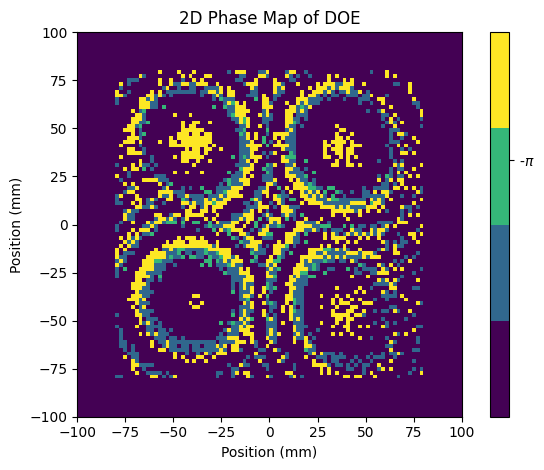

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

size_x = np.array(1 * mm * 200 / 2)
unit_val, unit_axis = float_to_unit_identifier(size_x)
size_x = size_x / unit_val

extent = [-size_x, size_x, -size_x, size_x]

phase_map = setup.hologram.q_phase - 2 * torch.pi # 100 x 100
upsample_phase_map = nn.functional.interpolate(phase_map, size=[100, 100], mode='nearest')
#aperture = setup.hologram.Mask # 200 x 200
phase_map = upsample_phase_map
phase_map = phase_map.squeeze(0,1).detach().cpu().numpy()

cmap = plt.get_cmap('viridis', 4)
#bounds = np.linspace(-np.pi, np.pi, 5) # 9 boundaries for 8 discrete values

#norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()

cax = ax.imshow(phase_map, extent=extent, cmap=cmap)
ax.set_title('2D Phase Map of DOE')
ax.set_xlabel("Position (" + unit_axis + ")")
ax.set_ylabel("Position (" + unit_axis + ")")

# Add a discrete colorbar with fractional π labels
ticks = np.linspace(-np.pi, np.pi, 5)
ticks = ticks[:-1]  # Positions for the ticks
tick_labels = ['-$\pi$', '-0.5$\pi$', '0', '0.5$\pi$']  # LaTeX formatted labels
cbar = fig.colorbar(cax, ticks=ticks)
cbar.ax.set_yticklabels(tick_labels)  # Set custom tick labels

plt.tight_layout()
plt.show()


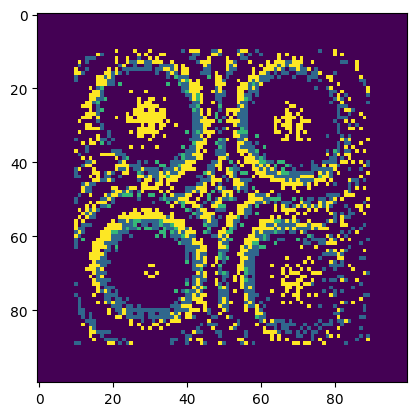

In [71]:
plt.imshow(phase_map)

In [34]:
bounds

NameError: name 'bounds' is not defined

In [84]:
ticks

array([-3.14159265, -1.04719755,  1.04719755,  3.14159265])

In [108]:
torch.rand(10)

tensor([0.7323, 0.4430, 0.5961, 0.7229, 0.5375, 0.6960, 0.0744, 0.9331, 0.0548,
        0.7367])